# Detecting Face Masks in Images (Keras)

#### Basic steps:
1. Given images, detect facial regions and features (find faces)
2. Create train/test data with facial regions as inputs
3. Using supervised model with training images, predict whether there is a mask in the facial region

#### Environment Setup

1. Use/create a new [Anaconda](https://www.anaconda.com/products/individual) environment with Python 3.6 (not 3.7 or 3.8), keras, and tensorflow:
``` sh
$ conda create -n <your_env_name> python=3.6 anaconda tensorflow keras
```
2. Install dependencies:
``` sh
$ conda install -c anaconda xlrd xlwt scikit-learn seaborn
$ conda install mtcnn ipyparallel validators
$ pip install python-opencv
```

In [1]:
# i hate this, but the notebook won't recognize our custom modules w/o it
import sys
sys.path.append("..")
import lib
from lib import utils

import numpy as np
import pandas as pd
import os
import urllib
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential        # keras is only compatible with python 3.6 or lower
import sklearn
from sklearn.preprocessing import LabelEncoder
from mtcnn.mtcnn import MTCNN
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
from sklearn.model_selection import StratifiedKFold


Using TensorFlow backend.


## Grab/Process Image Data

1. For our purposes as of the time of writing this, there should be a prepared dataframe for images not in our training set located in the data directory: `data/img_data/unclassified.csv`
  + The prepared data frame is made up of rows containing the image filename, the coordinates of one face's bounding box, and an empty column 'classname' where the classification results would otherwise be.
2. Currently, we're using the training set from Kaggle's medical masks dataset.
  + This data is similarly prepared already, but it has it's classname column filled (mask/no mask/colorful mask)
  + Ideally, we could get some additional images for the training set containing masks that are not strictly 'medical' looking (anything that effectively covers the nose and mouth: bandanas, etc)


In [2]:
# GITHUB IMAGE LOCATIONS/HELPERS (maybe we can save some local space)
IMAGES_DIR_GIT = "https://github.com/brtonnies/face-mask-detection/blob/main/data/images"
CMFD_DIR_GIT = "https://github.com/brtonnies/face-mask-detection/blob/main/data/images/CMFD/images"
IMFD_DIR_GIT = "https://github.com/brtonnies/face-mask-detection/blob/main/data/images/IMFD/images"

# define directory paths for easier navigation
NOTEBOOK_DIR = !pwd
NOTEBOOK_DIR = NOTEBOOK_DIR[0]
ROOT_DIR = os.path.abspath(os.path.join(NOTEBOOK_DIR, os.pardir))
DATA_DIR = os.path.join(ROOT_DIR, 'data')
IMAGES_DIR = os.path.join(DATA_DIR, 'images')
ANNOTATIONS_DIR = os.path.join(DATA_DIR, 'annotations')
SUB_IMAGES_DIR = os.path.join(IMAGES_DIR, 'sub')

'0001.jpg'.split(".")[-1]

'jpg'

In [9]:
https://github.com/brtonnies/face-mask-detection/blob/main/data/images/0001.jpg?raw=true
name = '0001.jpg'
options = {
    'lib': 'plt',
    'format': name.split(".")[-1]
}

img = utils.get_kaggle_img(name, options)


plt.imshow(img)
plt.show()
options

SyntaxError: invalid syntax (<ipython-input-9-1c9e2351caca>, line 1)

In [10]:
# load Kaggle training data
df_train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
df_train.rename(
    columns={'x1': 'x', 'x2': 'y', 'y1': 'w', 'y2': 'h'},
    inplace=True
)
df_train.sort_values('name', axis = 0, inplace = True)
df_train

,name,x,y,w,h,classname
13381,1801.jpg,451,186,895,697,face_no_mask
3464,1802.jpg,160,151,268,265,mask_surgical
3463,1802.jpg,110,71,273,272,face_with_mask
14836,1803.jpg,147,200,288,320,mask_surgical
14835,1803.jpg,126,75,303,333,face_with_mask
...,...,...,...,...,...,...
13555,6433.png,669,205,774,282,mask_surgical
9508,6434.jpg,315,82,775,783,face_with_mask
9507,6434.jpg,343,448,756,774,mask_colorful
9434,6435.jpg,198,86,292,149,mask_surgical


In [5]:
# load testing data
if os.path.exists(os.path.join(DATA_DIR, 'img_data/not_classified.csv')):

    df_test = pd.read_csv(
        os.path.join(DATA_DIR, 'img_data/not_classified.csv'),
        index_col=0
    )
    df_test.rename(
        columns={'x1': 'x', 'x2': 'y', 'y1': 'w', 'y2': 'h'},
        inplace=True
    )
    df_test.sort_values('name', axis = 0, inplace = True)
else:
    df_test = None

df_test

array(['face_no_mask', 'mask_surgical', 'face_with_mask', 'hat',
       'eyeglasses', 'face_other_covering', 'face_with_mask_incorrect',
       'mask_colorful', 'sunglasses', 'helmet', 'scarf_bandana',
       'hair_net', 'face_shield', 'goggles', 'hijab_niqab', 'turban',
       'balaclava_ski_mask', 'gas_mask', 'hood', 'other'], dtype=object)

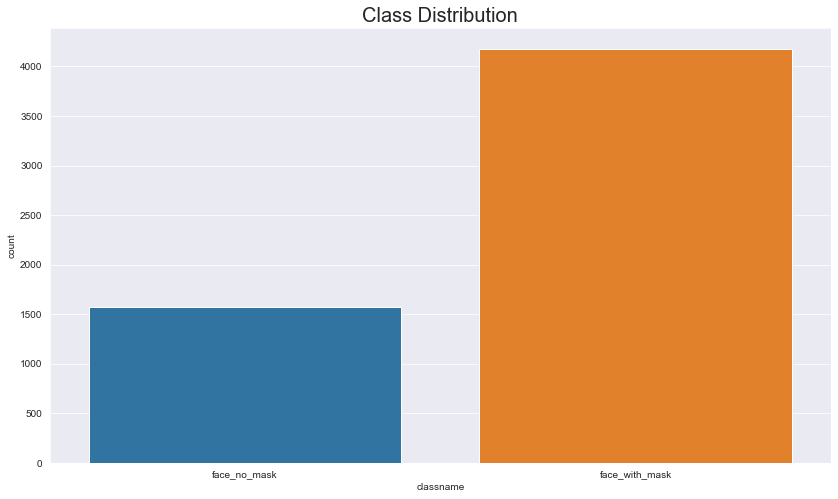

In [6]:
classes = df_train['classname'].unique()
_classes = np.insert(classes, 0, "background", axis=0)        # adding a background class for Faster R-CNN
class_to_int = {_classes[i] : i for i in range(len(_classes))}
int_to_class = {i : _classes[i] for i in range(len(_classes))}

# specify which classnames we want to look at
options = [
    'face_with_mask', 
    'face_no_mask', 
    # 'mask_colorful',
    # 'face_with_mask_incorrect',
]

### Visualizing Class Distribution
plt.figure(figsize=(14,8))
plt.title('Class Distribution', fontsize= 20)

sns.countplot(x = "classname", data = df_train[df_train["classname"].isin(options)])
classes

In [7]:
train = df_train[df_train['classname'].isin(options)]
train.sort_values('name', axis=0, inplace=True)

/Users/kellymcgaw/opt/anaconda3/envs/mm/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Up Next:

1. We'll need to be able to look at each facial region within an image
2. We'll also need to keep the data somewhere
3. We also need to define and train a keras model before we can make any predictions 

## We know where our faces are... let's get our training data ready for the model

In [8]:
# train_images = df_train['name'].unique()
data = list()
# for image in train_images:
for i in range(len(train)):
    # name, x, y, w, h, classname = list(df_train[df_train['name'] == image].values[0])
    name, x, y, w, h, classname = list(train.iloc[i])
    print(name, x, y, w, h, classname)
    imgs = plt.imread(os.path.join(IMAGES_DIR_GIT, "{}?raw=true".format(name)), format='jpg')
#     og_img = cv2.imread(os.path.join(IMAGES_DIR_GIT, "{}?raw=true".format(name)), cv2.IMREAD_GRAYSCALE)
    og_img = cv2.imread(imgs, cv2.IMREAD_GRAYSCALE)
    cv2.imshow('image', og_img)
    cropped = og_img[y:h, x:w]
    if len(cropped) > 0:
        new_img = cv2.resize(cropped, (50, 50)) # resize img to 50x50
        data.append([new_img, classname])
    

len(data)

1801.jpg 451 186 895 697 face_no_mask


FileNotFoundError: [Errno 2] No such file or directory: 'https://github.com/brtonnies/face-mask-detection/blob/main/data/images/1801.jpg?raw=true'

In [15]:
plt.imshow(data[0][0])

IndexError: list index out of range

## A Few More Steps:
1. Split training data into features and labels
2. Convert labels to categorical values and reshape features
3. Define/train a model on the training set

In [11]:
# split into labels/features
x=[]
y=[]
for features, labels in data:
    x.append(features)
    y.append(labels)

# convert labels to categorical values
labeler = LabelEncoder()
y = labeler.fit_transform(y)
y

array([], dtype=int64)

In [12]:
# reshape features
x = np.array(x).reshape(-1, 50, 50, 1)
x = tf.keras.utils.normalize(x, axis=1)
y = to_categorical(y)

y.shape

ValueError: zero-size array to reduction operation maximum which has no identity

## Model Creation/Fitting

1. Keras models can be created, compiled, trained, and then *saved* to a file and/or loaded from one.
2. If there isn't a model file available, we have to create it.
  + This takes awhile, so if there is an already trained/fit model, we're gonna use it

### Model Choice: Keras Sequential Model


In [21]:
model_path = "../models/keras_sequential_model"
# fix random seed for reproducibility
seed = 7
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
if os.path.exists(model_path):
    model = keras.models.load_model(model_path)

else:
    batch_size = 5
    epochs = 30
    learning_rate = 1e-3
    epsilon = 1e-5

    model = Sequential()
    model.add(Conv2D(100, (3, 3), input_shape=x.shape[1:], activation='relu', strides=2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    opt = keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x, y, epochs=epochs, batch_size=batch_size)
    model.save(model_path)

In [78]:
def get_faces(img):
    detector = MTCNN()
    image = plt.imread(os.path.join(IMAGES_DIR, img))
    return detector.detect_faces(image)

def face_bounds(face):
    return face['box']

# Let's Predict?

In [ ]:
seed = 7
numpy.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

batch_size = 5
epochs = 30
learning_rate = 1e-3
epsilon = 1e-5

model = Sequential()
model.add(Conv2D(100, (3, 3), input_shape=x.shape[1:], activation='relu', strides=2))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x, y, epochs=epochs, batch_size=batch_size)
model.save(model_path)